In [1]:
import gzip

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt

# Preprocessing

## Meta data

In [2]:
def read_geo_series_matrix(file_path):
    cols = {}
    with gzip.open(file_path, 'rt') as f:
        for line in f:
            if line.startswith("!Sample_title"):
                sampleId = [i.strip('"') for i in line.split()[1:]]
                cols["sampleId"] = sampleId
            elif line.startswith("!Sample_characteristics_ch1"):
                _ = line[28:].strip().strip('"').split('"\t"')
                category = _[0].split(": ")[0].replace(" ", "_")
                values = [i.split(": ")[1] for i in _]
                cols.update({category: values})
    
    return pd.DataFrame(cols)

In [3]:
meta = read_geo_series_matrix("../rawData/GSE49711_series_matrix.txt.gz")
meta.index = meta.sampleId
meta.shape

(498, 11)

In [4]:
meta = meta.loc[meta.class_label.isin(["0", "1"])]
meta.shape

(272, 11)

In [5]:
meta.class_label.value_counts()

0    181
1     91
Name: class_label, dtype: int64

In [7]:
pd.crosstab(meta.inss_stage, meta.class_label)

class_label,0,1
inss_stage,,
1,100,1
2,44,4
3,7,14
4,0,68
4S,30,4


In [8]:
pd.crosstab(meta.high_risk, meta.class_label)

class_label,0,1
high_risk,,
0,181,13
1,0,78


In [9]:
meta.Sex.replace({"M":1, "F":0}, inplace=True)
meta.replace({"N/A":np.nan}, inplace=True)

In [10]:
stage_dummy = pd.get_dummies(meta.inss_stage, prefix='inss_stage')
meta = pd.concat([meta, stage_dummy], axis=1)

In [11]:
meta.dropna(inplace=True)

In [12]:
meta = meta[["Sex", "age_at_diagnosis", 
              "high_risk", "class_label"
              ]]

In [13]:
meta = meta.astype("double")

In [14]:
meta.head()

,Sex,age_at_diagnosis,high_risk,class_label
sampleId,,,,
SEQC_NB001,1.0,987.0,1.0,1.0
SEQC_NB002,1.0,1808.0,1.0,1.0
SEQC_NB003,0.0,625.0,1.0,1.0
SEQC_NB005,0.0,536.0,1.0,1.0
SEQC_NB006,1.0,147.0,0.0,0.0


## Gene level

In [15]:
rna = pd.read_table("../rawData/GSE49711_SEQC_NB_TAV_G_log2.final.txt.gz")
rna = rna[~ rna.Gene.str.contains("[a-z]")]
rna.drop(["Gene_set","NCBI_gene_ID","RefSeq_transcript_ID","Chromosome","Strand","Start","End"], axis=1, inplace=True)
X = rna.iloc[:,1:].transpose()
X.columns = rna.Gene

In [16]:
X = X.loc[meta.index] # keep only samples with valid Ys

In [17]:
X_train, X_, y_train, y_ = train_test_split(X, meta.class_label.astype("int"), test_size=0.3, random_state=1234)

In [18]:
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size = 0.5, random_state=1234)

# QC

In [19]:
X_train

Gene,A1BGAS,A1CF,A2BP1,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AAA1,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZZEF1,ZZZ3
sampleId,,,,,,,,,,,,,,,,,,,,,
SEQC_NB096,16.1434,0.0000,19.0748,15.2934,20.7683,11.5196,0.0000,14.7459,11.5679,0.0000,...,19.0694,14.8084,15.7586,18.6447,8.6691,0.0,19.1588,19.9347,19.0222,18.5647
SEQC_NB171,16.6942,0.0000,19.3659,16.2770,20.4752,11.3862,0.0000,14.6333,0.0000,9.5845,...,17.2522,15.3770,16.3842,17.5520,8.2163,0.0,19.8668,19.5434,19.2513,18.5950
SEQC_NB269,16.5818,0.0000,14.1723,14.8611,21.1105,0.0000,0.0000,16.0039,11.6946,0.0000,...,19.0551,15.3910,16.7814,18.5558,12.1821,0.0,19.2358,20.5655,18.6922,18.7672
SEQC_NB049,16.7387,10.4891,18.7599,15.1532,22.9345,12.7586,12.7942,16.7859,11.4065,0.0000,...,16.8487,15.0145,16.8378,18.2700,11.0086,0.0,20.2806,20.5645,19.2627,19.1636
SEQC_NB172,16.2936,0.0000,17.7391,14.2521,20.8566,0.0000,11.6096,17.2614,11.4280,0.0000,...,18.0842,14.3071,15.9978,17.8533,9.1085,0.0,19.6168,20.0779,19.0250,19.0993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEQC_NB218,17.2790,0.0000,18.4650,14.6535,20.3641,13.4018,0.0000,14.5823,11.6175,0.0000,...,18.7860,14.6715,16.2595,18.8309,10.5602,0.0,19.9761,20.0579,19.3179,18.6212
SEQC_NB244,17.2562,10.6036,18.8896,15.7909,22.0597,10.9153,11.1139,16.4155,11.7244,10.4736,...,16.1998,15.2354,16.8942,18.4276,12.9273,0.0,19.9850,21.0383,19.1075,18.5479
SEQC_NB328,16.6707,0.0000,18.9982,13.2940,18.0203,11.4796,0.0000,13.2410,0.0000,7.9131,...,19.4974,14.9767,16.5994,18.1310,12.3963,0.0,19.6283,19.0428,18.5762,19.4349


<Axes: >

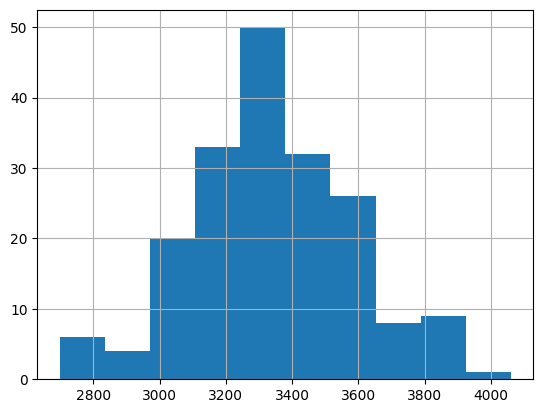

In [17]:
(X_train == 0).sum(axis=1).hist() # per-sample expression

<Axes: >

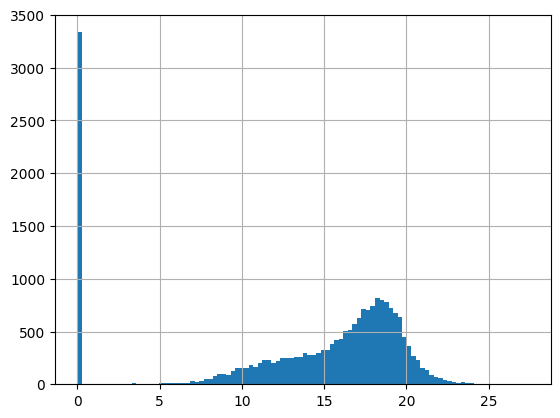

In [18]:
X_train.median().hist(bins=100)

In [27]:
sum( X_train.median() <= 5)

3417

In [28]:
X_train = X_train.loc[:, X_train.median() > 5]

In [29]:
X_train.shape

(189, 17706)

In [30]:
X_train

Gene,A1BGAS,A2BP1,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,AACS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
sampleId,,,,,,,,,,,,,,,,,,,,,
SEQC_NB096,16.1434,19.0748,15.2934,20.7683,11.5196,0.0000,14.7459,11.5679,19.8594,18.6028,...,18.9712,19.0694,14.8084,15.7586,18.6447,8.6691,19.1588,19.9347,19.0222,18.5647
SEQC_NB171,16.6942,19.3659,16.2770,20.4752,11.3862,0.0000,14.6333,0.0000,19.3421,17.6418,...,18.4411,17.2522,15.3770,16.3842,17.5520,8.2163,19.8668,19.5434,19.2513,18.5950
SEQC_NB269,16.5818,14.1723,14.8611,21.1105,0.0000,0.0000,16.0039,11.6946,19.7536,18.1755,...,18.9633,19.0551,15.3910,16.7814,18.5558,12.1821,19.2358,20.5655,18.6922,18.7672
SEQC_NB049,16.7387,18.7599,15.1532,22.9345,12.7586,12.7942,16.7859,11.4065,19.4793,17.4337,...,17.3081,16.8487,15.0145,16.8378,18.2700,11.0086,20.2806,20.5645,19.2627,19.1636
SEQC_NB172,16.2936,17.7391,14.2521,20.8566,0.0000,11.6096,17.2614,11.4280,19.6679,18.7213,...,17.9166,18.0842,14.3071,15.9978,17.8533,9.1085,19.6168,20.0779,19.0250,19.0993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEQC_NB218,17.2790,18.4650,14.6535,20.3641,13.4018,0.0000,14.5823,11.6175,20.3679,18.9736,...,18.4607,18.7860,14.6715,16.2595,18.8309,10.5602,19.9761,20.0579,19.3179,18.6212
SEQC_NB244,17.2562,18.8896,15.7909,22.0597,10.9153,11.1139,16.4155,11.7244,19.3001,18.0834,...,17.0470,16.1998,15.2354,16.8942,18.4276,12.9273,19.9850,21.0383,19.1075,18.5479
SEQC_NB328,16.6707,18.9982,13.2940,18.0203,11.4796,0.0000,13.2410,0.0000,20.2103,19.1887,...,18.7715,19.4974,14.9767,16.5994,18.1310,12.3963,19.6283,19.0428,18.5762,19.4349


In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

In [32]:
X_val_scaled = scaler.transform(X_val.loc[:, X_train.columns])
X_val_scaled = pd.DataFrame(X_val_scaled, index=X_val.index, columns=X_train.columns)

In [33]:
X_test_scaled = scaler.transform(X_test.loc[:, X_train.columns])
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_train.columns)

In [34]:
meta_train = meta.loc[X_train.index]
age_scaler = StandardScaler()
age_at_diagnosis = age_scaler.fit_transform(np.array(meta_train.age_at_diagnosis).reshape(-1, 1))
meta_train.age_at_diagnosis = age_at_diagnosis
meta_train.drop(["class_label", "high_risk"], axis = 1, inplace=True)

In [35]:
X_train_scaled = pd.concat([X_train_scaled, meta_train], axis=1)

In [36]:
meta_val = meta.loc[X_val.index]
age_at_diagnosis = age_scaler.transform(np.array(meta_val.age_at_diagnosis).reshape(-1, 1))
meta_val.age_at_diagnosis = age_at_diagnosis
meta_val.drop(["class_label", "high_risk"], axis = 1, inplace=True)

In [37]:
X_val_scaled = pd.concat([X_val_scaled, meta_val], axis=1)

In [38]:
meta_test = meta.loc[X_test.index]
age_at_diagnosis = age_scaler.transform(np.array(meta_test.age_at_diagnosis).reshape(-1, 1))
meta_test.age_at_diagnosis = age_at_diagnosis
meta_test.drop(["class_label", "high_risk"], axis = 1, inplace=True)

In [39]:
X_test_scaled = pd.concat([X_test_scaled, meta_test], axis=1)

# L1 Logistic regression

In [40]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report

In [41]:
model = LogisticRegressionCV(penalty='l1', solver='liblinear', cv = 5, random_state=1234, Cs= 30, class_weight="balanced", n_jobs= 4)
model.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=30, class_weight='balanced', cv=5, n_jobs=4,
                     penalty='l1', random_state=1234, solver='liblinear')

In [42]:
# Make predictions on the val set
y_pred = model.predict(X_val_scaled)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)

In [43]:
accuracy

0.975

In [44]:
roc_auc_score(y_val, y_pred)

0.95

In [45]:
pd.crosstab(y_pred, y_val)

class_label,0,1
row_0,,
0,30,1
1,0,9


In [46]:
pd.crosstab(meta.loc[y_val.index].high_risk, meta.loc[y_val.index].class_label)

class_label,0.0,1.0
high_risk,,
0.0,30,2
1.0,0,8


In [47]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      0.90      0.95        10

    accuracy                           0.97        40
   macro avg       0.98      0.95      0.97        40
weighted avg       0.98      0.97      0.97        40



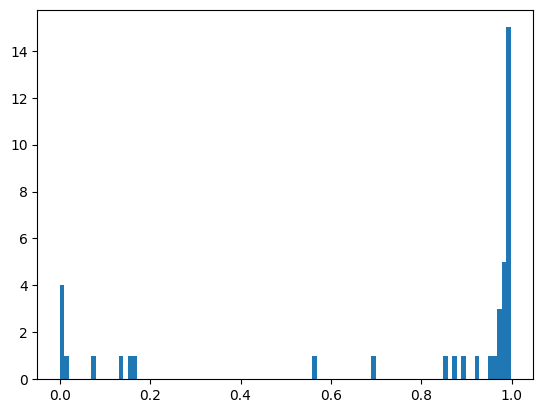

In [48]:
_ = plt.hist(model.predict_proba(X_val_scaled)[:,0], 100)

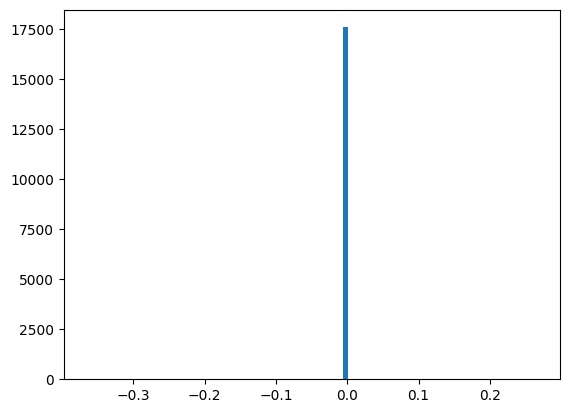

In [49]:
_ = plt.hist(model.coef_[0], 100)

In [50]:
sum(model.coef_[0] != 0)

143

In [119]:
indices = np.argsort(model.coef_[0])[::-1]

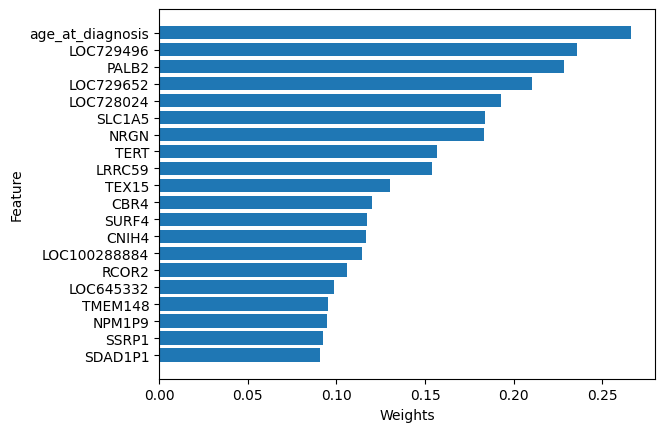

In [120]:
plt.barh(X_train_scaled.columns[indices][range(20)][::-1], model.coef_[0][indices][range(20)][::-1])
plt.xlabel("Weights")
plt.ylabel("Feature")
plt.show()

In [85]:
num_columns_to_sample = 5000
matrix = model.coefs_paths_[1][1]
random_column_indices = np.random.choice(matrix.shape[1], num_columns_to_sample, replace=False)

# Select the sampled columns
sampled_columns = matrix[:, random_column_indices]

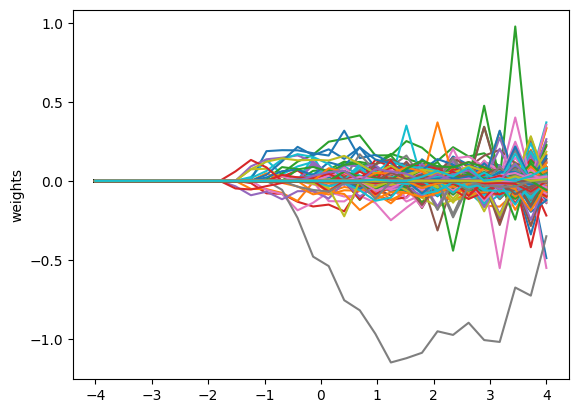

In [86]:
plt.plot(np.log10(model.Cs_), sampled_columns)
plt.ylabel("weights")
plt.show()

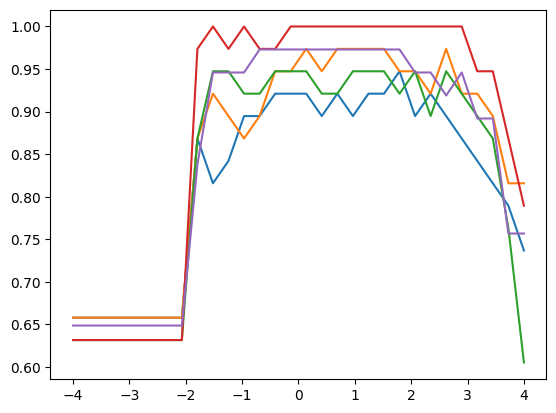

In [44]:
plt.plot(np.log10(model.Cs_), model.scores_[1].T)
plt.show()

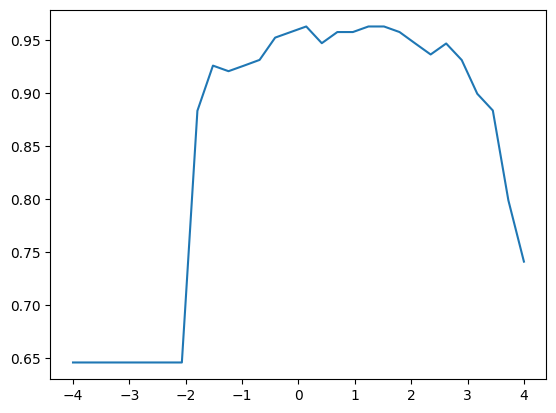

In [45]:
plt.plot(np.log10(model.Cs_), np.mean(model.scores_[1].T, axis = 1))
plt.show()

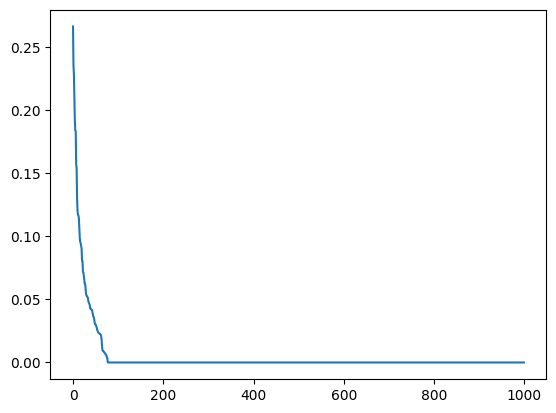

In [46]:
plt.plot(model.coef_[0][indices][range(1000)])


# Ranodm forest

In [87]:
from sklearn.ensemble import RandomForestClassifier


In [88]:
X_train = pd.concat([X_train, meta_train], axis=1)
X_val = pd.concat([X_val, meta_val], axis=1)
X_test = pd.concat([X_test, meta_test], axis = 1)

<Axes: >

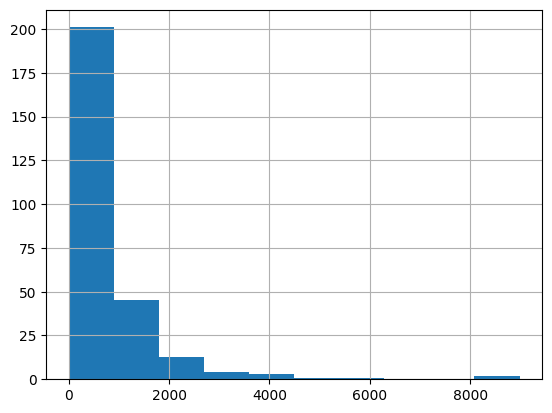

In [127]:
meta.age_at_diagnosis.hist()

<Axes: >

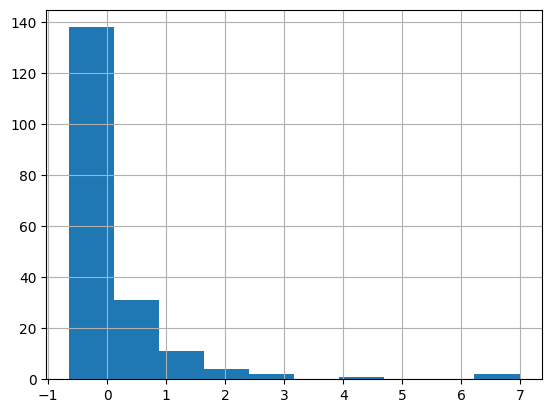

In [126]:
X_train.age_at_diagnosis.hist()

In [89]:
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=1234, class_weight="balanced", n_jobs=4)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=1000, n_jobs=4,
                       random_state=1234)

In [90]:
y_pred = rf_classifier.predict(X_val.loc[:, X_train.columns])
accuracy = accuracy_score(y_val, y_pred)

In [91]:
accuracy

1.0

In [92]:
roc_auc_score(y_val, y_pred)

1.0

In [93]:
pd.crosstab(y_pred, y_val)

class_label,0,1
row_0,,
0,30,0
1,0,10


In [94]:
pd.crosstab(meta.loc[y_val.index].high_risk, meta.loc[y_val.index].class_label)

class_label,0.0,1.0
high_risk,,
0.0,30,2
1.0,0,8


In [95]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [121]:
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

In [97]:
# Print the feature ranking
print("Feature ranking:")
for f in range(20):
    print("%d. %s: feature %d (%f)" % (f + 1, X_train.columns[indices[f]], indices[f], importances[indices[f]]))

Feature ranking:
1. CNIH4: feature 2471 (0.009670)
2. PRKACB: feature 12095 (0.007774)
3. CAMTA1: feature 1570 (0.007478)
4. PIRT: feature 11584 (0.007058)
5. MRPL11: feature 9869 (0.006817)
6. FAM72D: feature 4366 (0.006658)
7. EXO1: feature 4033 (0.006592)
8. SLC25A5: feature 14322 (0.006120)
9. EPS8L1: feature 3938 (0.005816)
10. NRCAM: feature 10698 (0.005495)
11. PGM2L1: feature 11450 (0.005439)
12. CDK4: feature 2057 (0.005195)
13. FENL1: feature 4576 (0.005181)
14. MINK1: feature 9693 (0.005129)
15. UHRF1: feature 16524 (0.005085)
16. INPP1: feature 6453 (0.004854)
17. CPNE2: feature 2654 (0.004834)
18. NRBP2: feature 10697 (0.004608)
19. PJA2: feature 11598 (0.004430)
20. PRMT5: feature 12130 (0.004427)


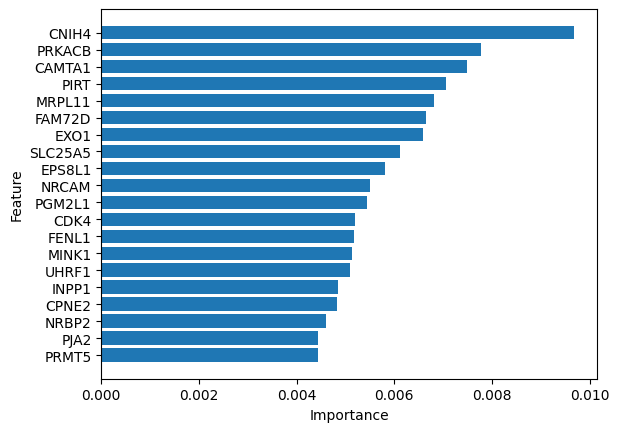

In [122]:
plt.barh(X_train.columns[indices][range(20)][::-1], importances[indices][range(20)][::-1])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

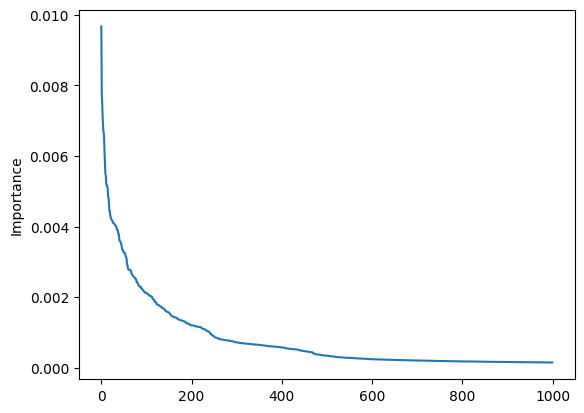

In [146]:
plt.plot(importances[indices][range(1000)])
plt.ylabel("Importance")
plt.show()


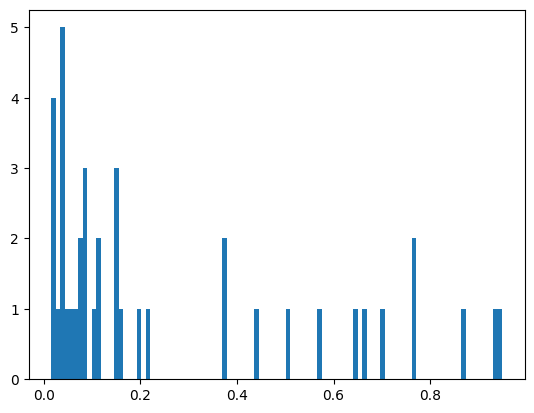

In [60]:
plt.hist(rf_classifier.predict_proba(X_val.loc[:, X_train.columns])[:,1], bins = 100)
plt.show()

# feature overlap

In [101]:
lr_top20_indices = np.argsort(model.coef_[0])[::-1][range(20)]
rf_top20_indices = np.argsort(importances)[::-1][range(20)]

In [115]:
lr_top50_indices = np.argsort(model.coef_[0])[::-1][range(50)]
rf_top50_indices = np.argsort(importances)[::-1][range(50)]

In [102]:
lr_top143_indices = np.argsort(model.coef_[0])[::-1][range(143)]
rf_top143_indices = np.argsort(importances)[::-1][range(143)]

In [109]:
from matplotlib_venn import venn2

In [123]:
set(X_train.columns[lr_top20_indices]) & set(X_train.columns[rf_top20_indices])

{'CNIH4'}

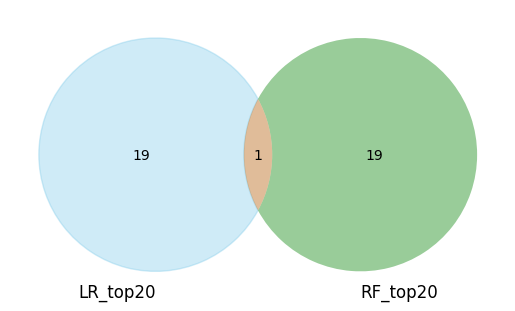

In [114]:
v = venn2([set(X_train.columns[lr_top20_indices]), set(X_train.columns[rf_top20_indices])], 
                     ('LR_top20', 'RF_top20'))
v.get_patch_by_id('100').set_color('skyblue')

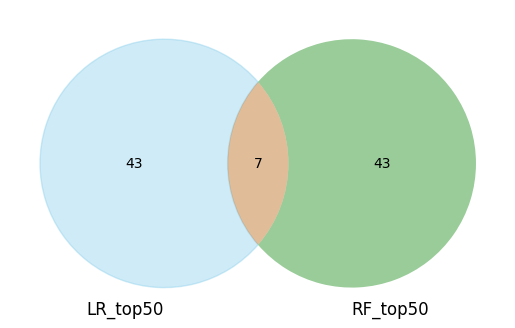

In [116]:
v = venn2([set(X_train.columns[lr_top50_indices]), set(X_train.columns[rf_top50_indices])], 
                     ('LR_top50', 'RF_top50'))
v.get_patch_by_id('100').set_color('skyblue')

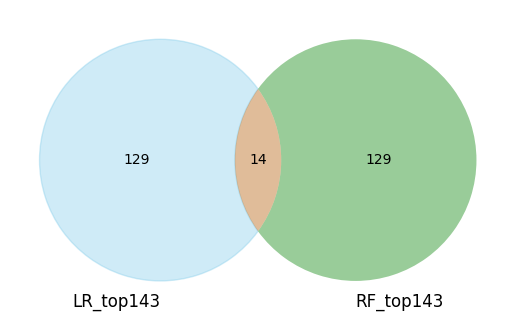

In [117]:
v = venn2([set(X_train.columns[lr_top143_indices]), set(X_train.columns[rf_top143_indices])], 
                     ('LR_top143', 'RF_top143'))
v.get_patch_by_id('100').set_color('skyblue')

# Test

In [130]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score


### LR 

In [131]:
print("L1 test acc:", accuracy_score(y_test, model.predict(X_test_scaled)))
print("L1 test auc:", roc_auc_score(y_test, model.predict(X_test_scaled)))
print("L1 test f1:", f1_score(y_test, model.predict(X_test_scaled)))

L1 test acc: 0.9512195121951219
L1 test auc: 0.9436813186813188
L1 test f1: 0.9230769230769231


In [132]:
print("L1 val acc:", accuracy_score(y_val, model.predict(X_val_scaled)))
print("L1 val auc:", roc_auc_score(y_val, model.predict(X_val_scaled)))
print("L1 val f1:", f1_score(y_val, model.predict(X_val_scaled)))

L1 val acc: 0.975
L1 val auc: 0.95
L1 val f1: 0.9473684210526316


In [62]:
pd.crosstab(model.predict(X_test_scaled), y_test)

class_label,0,1
row_0,,
0,27,1
1,1,12


### RF

In [133]:
print("RF test acc:", accuracy_score(y_test, rf_classifier.predict(X_test.loc[:, X_train.columns])))
print("RF test auc:", roc_auc_score(y_test, rf_classifier.predict(X_test.loc[:, X_train.columns])))
print("RF test f1:", f1_score(y_test, rf_classifier.predict(X_test.loc[:, X_train.columns])))

RF test acc: 0.975609756097561
RF test auc: 0.9615384615384616
RF test f1: 0.9600000000000001


In [134]:
print("RF val acc:", accuracy_score(y_val, rf_classifier.predict(X_val.loc[:, X_train.columns])))
print("RF val auc:", roc_auc_score(y_val, rf_classifier.predict(X_val.loc[:, X_train.columns])))
print("RF val f1:", f1_score(y_val, rf_classifier.predict(X_val.loc[:, X_train.columns])))

RF val acc: 1.0
RF val auc: 1.0
RF val f1: 1.0


In [135]:
pd.crosstab(rf_classifier.predict(X_test.loc[:, X_train.columns]), y_test)

class_label,0,1
row_0,,
0,28,1
1,0,12


In [ ]:
# acc, auc, f1
lr_val_scores = [0.975, 0.95, 0.95]
lr_test_scores = [0.95, 0.94, 0.92]

rf_val_scores = [1,1,1]
rf_test_scores = [0.98, 0.96, 0.96]